In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# Data Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive
import pandas as pd
import shutil
import random

### Data Exploration on tumor_091 at level 5

In [7]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   127M      0  0:00:04  0:00:04 --:--:--  127M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  58.1M      0 --:--:-- --:--:-- --:--:-- 58.1M


In [8]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

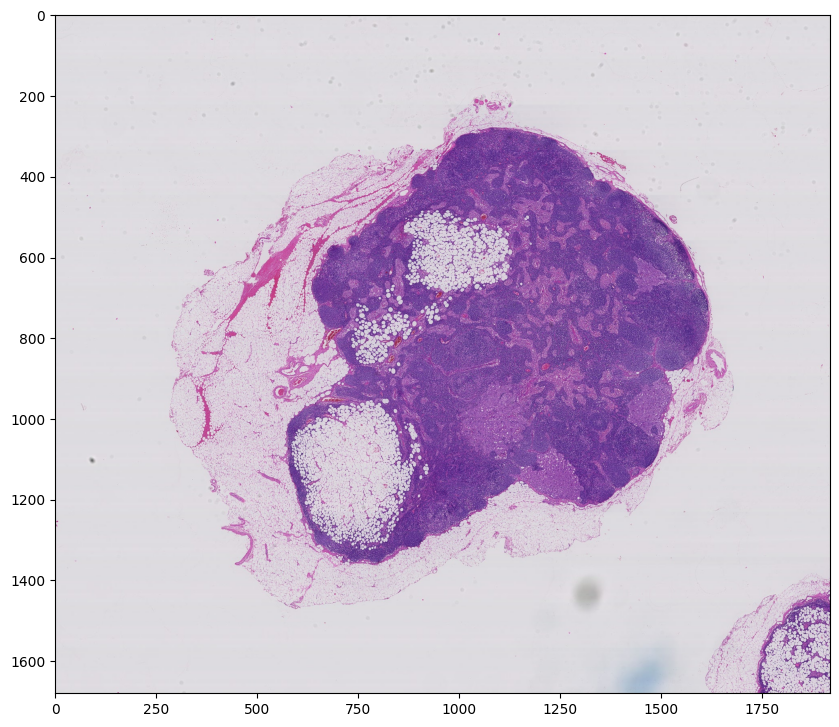

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

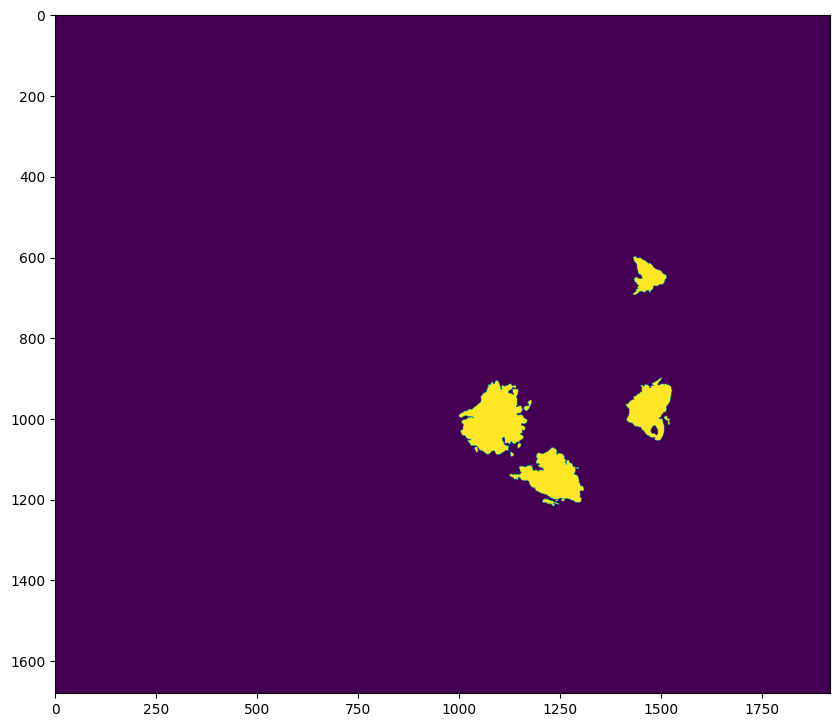

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

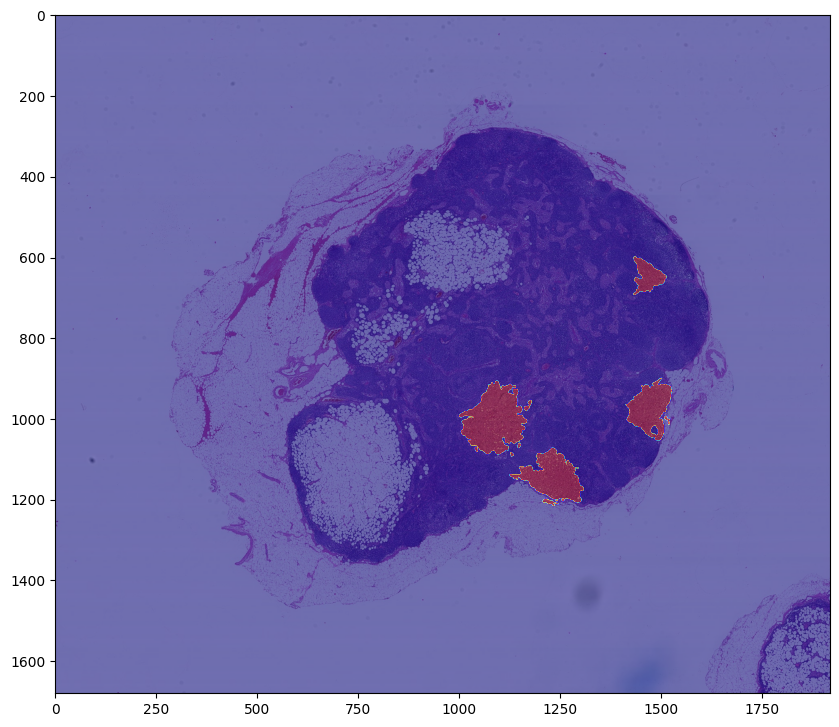

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

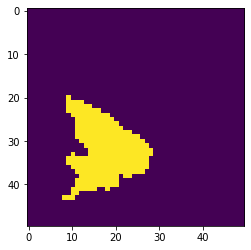

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=130 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (28.1 percent of the image)


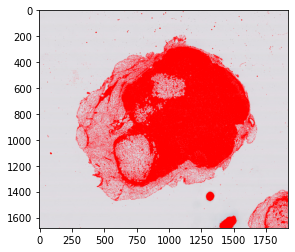

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Save Slices to Disk

In [2]:
drive.mount('/content/gdrive/')
drive_root_dir = '/content/gdrive/MyDrive/'
slides_directory_path = drive_root_dir+'slides/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
from generate_slices import Slide2Slice

In [5]:
all_data_slides=[ 'tumor_001', 'tumor_002', 'tumor_005', 
                   'tumor_012', 'tumor_016', 'tumor_019', 
                   'tumor_023', 'tumor_031', 'tumor_035', 
                   'tumor_057', 'tumor_059', 'tumor_064',
                   'tumor_075', 'tumor_078', 'tumor_081', 
                   'tumor_084', 'tumor_091', 'tumor_094', 
                   'tumor_096', 'tumor_101', 'tumor_110',]

train_data_slides = all_data_slides[:18] # 18 Training Slides
test_data_slides = all_data_slides[18:] # 3 Testing Slides
train_sliced_slides_dir = drive_root_dir + 'slices_train/'
test_sliced_slides_dir = drive_root_dir + 'slices_test/'

### Level 3

In [ ]:
level = 3
slice_size = 299

In [ ]:
# ! rm -r '/content/gdrive/My Drive/slices_train/level3/'

In [ ]:
stats_df = Slide2Slice(train_data_slides,
                       slides_directory_path, 
                       sliced_slides_dir=train_sliced_slides_dir, 
                       level=level,
                       slice_size=slice_size).run()

slicing tumor_001 on level 3 and size 299
{'slide_name': 'tumor_001', 'level': 3, 'negative': 3671, 'positive': 9, 'negative_with_tissue': 627, 'positive_with_tissue': 9}
slicing tumor_002 on level 3 and size 299
{'slide_name': 'tumor_002', 'level': 3, 'negative': 3638, 'positive': 2, 'negative_with_tissue': 333, 'positive_with_tissue': 2}
slicing tumor_005 on level 3 and size 299
{'slide_name': 'tumor_005', 'level': 3, 'negative': 3638, 'positive': 2, 'negative_with_tissue': 329, 'positive_with_tissue': 2}
slicing tumor_012 on level 3 and size 299
{'slide_name': 'tumor_012', 'level': 3, 'negative': 3596, 'positive': 4, 'negative_with_tissue': 376, 'positive_with_tissue': 4}
slicing tumor_016 on level 3 and size 299
{'slide_name': 'tumor_016', 'level': 3, 'negative': 3625, 'positive': 55, 'negative_with_tissue': 292, 'positive_with_tissue': 52}
slicing tumor_019 on level 3 and size 299
{'slide_name': 'tumor_019', 'level': 3, 'negative': 3637, 'positive': 3, 'negative_with_tissue': 274,

In [ ]:
stats_df.to_csv('level3.csv')
stats_df

slide_name level negative positive negative_with_tissue positive_with_tissue
0   tumor_001     3     3671        9                  627                    9
1   tumor_002     3     3638        2                  333                    2
2   tumor_005     3     3638        2                  329                    2
3   tumor_012     3     3596        4                  376                    4
4   tumor_016     3     3625       55                  292                   52
5   tumor_019     3     3637        3                  274                    3
6   tumor_023     3     3673        7                  368                    7
7   tumor_031     3     3611       69                  171                   66
8   tumor_035     3     3678        2                  364                    2
9   tumor_057     3     3671        9                  362                    8
10  tumor_059     3     3679        1                  326                    1
11  tumor_064     3     3617       63                  324                   54
12  tumor_075     3     1147       37                  299                   35
13  tumor_078     3     1464      330                  565                  322
14  tumor_081     3     1516        1                  539                    1
15  tumor_084     3      917       28                  346                   28
16  tumor_091     3      523       27                  208                   27
17  tumor_094     3     1987       22                  822                   22

In [ ]:
test_stats_df = pd.DataFrame()
level_df = Slide2Slice(test_data_slides,
                        slides_directory_path, 
                        sliced_slides_dir=test_sliced_slides_dir, 
                        level=level,
                        slice_size=slice_size,
                        save=False).run()
test_stats_df = test_stats_df.append(level_df, ignore_index=True)


slicing tumor_096 on level 3 and size 299
{'slide_name': 'tumor_096', 'level': 3, 'negative': 1539, 'positive': 27, 'negative_with_tissue': 555, 'positive_with_tissue': 27}
slicing tumor_101 on level 3 and size 299
{'slide_name': 'tumor_101', 'level': 3, 'negative': 1600, 'positive': 82, 'negative_with_tissue': 488, 'positive_with_tissue': 81}
slicing tumor_110 on level 3 and size 299
{'slide_name': 'tumor_110', 'level': 3, 'negative': 856, 'positive': 275, 'negative_with_tissue': 257, 'positive_with_tissue': 272}


In [ ]:
test_stats_df.to_csv('level3_test.csv')
test_stats_df

slide_name level negative positive negative_with_tissue positive_with_tissue
0  tumor_096     3     1539       27                  555                   27
1  tumor_101     3     1600       82                  488                   81
2  tumor_110     3      856      275                  257                  272

### Level 4

In [ ]:
level = 4
slice_size = 299

In [ ]:
# ! rm -r '/content/gdrive/My Drive/slices_train/level4/'

rm: cannot remove '/content/gdrive/My Drive/slices_train/level4/': No such file or directory


In [ ]:
stats_df = Slide2Slice(train_data_slides,
                       slides_directory_path, 
                       sliced_slides_dir=train_sliced_slides_dir, 
                       level=level,
                       slice_size=slice_size).run()

slicing tumor_001 on level 4 and size 299
{'slide_name': 'tumor_001', 'level': 4, 'negative': 913, 'positive': 7, 'negative_with_tissue': 178, 'positive_with_tissue': 7}
slicing tumor_002 on level 4 and size 299
{'slide_name': 'tumor_002', 'level': 4, 'negative': 899, 'positive': 1, 'negative_with_tissue': 61, 'positive_with_tissue': 1}
slicing tumor_005 on level 4 and size 299
{'slide_name': 'tumor_005', 'level': 4, 'negative': 898, 'positive': 2, 'negative_with_tissue': 64, 'positive_with_tissue': 2}
slicing tumor_012 on level 4 and size 299
{'slide_name': 'tumor_012', 'level': 4, 'negative': 896, 'positive': 4, 'negative_with_tissue': 83, 'positive_with_tissue': 2}
slicing tumor_016 on level 4 and size 299
{'slide_name': 'tumor_016', 'level': 4, 'negative': 900, 'positive': 20, 'negative_with_tissue': 54, 'positive_with_tissue': 19}
slicing tumor_019 on level 4 and size 299
{'slide_name': 'tumor_019', 'level': 4, 'negative': 897, 'positive': 3, 'negative_with_tissue': 50, 'positive_

In [ ]:
stats_df.to_csv('level4.csv')
stats_df

slide_name level negative positive negative_with_tissue positive_with_tissue
0   tumor_001     4      913        7                  178                    7
1   tumor_002     4      899        1                   61                    1
2   tumor_005     4      898        2                   64                    2
3   tumor_012     4      896        4                   83                    2
4   tumor_016     4      900       20                   54                   19
5   tumor_019     4      897        3                   50                    3
6   tumor_023     4      914        6                   86                    6
7   tumor_031     4      898       22                   28                   21
8   tumor_035     4      918        2                   95                    2
9   tumor_057     4      913        7                   68                    6
10  tumor_059     4      919        1                   87                    1
11  tumor_064     4      892       28                   75                   26
12  tumor_075     4      273       15                   76                   14
13  tumor_078     4      327      110                  134                  104
14  tumor_081     4      359        1                  153                    1
15  tumor_084     4      208       13                   91                   13
16  tumor_091     4      120       12                   52                   11
17  tumor_094     4      471        9                  201                    9

In [ ]:
test_stats_df = pd.DataFrame()
level_df = Slide2Slice(test_data_slides,
                        slides_directory_path, 
                        sliced_slides_dir=test_sliced_slides_dir, 
                        level=level,
                        slice_size=slice_size,
                        save=False).run()
test_stats_df = test_stats_df.append(level_df, ignore_index=True)


slicing tumor_096 on level 4 and size 299
{'slide_name': 'tumor_096', 'level': 4, 'negative': 364, 'positive': 14, 'negative_with_tissue': 147, 'positive_with_tissue': 13}
slicing tumor_101 on level 4 and size 299
{'slide_name': 'tumor_101', 'level': 4, 'negative': 366, 'positive': 40, 'negative_with_tissue': 127, 'positive_with_tissue': 37}
slicing tumor_110 on level 4 and size 299
{'slide_name': 'tumor_110', 'level': 4, 'negative': 178, 'positive': 88, 'negative_with_tissue': 61, 'positive_with_tissue': 82}


In [ ]:
test_stats_df.to_csv('level4_test.csv')
test_stats_df

slide_name level negative positive negative_with_tissue positive_with_tissue
0  tumor_096     4      364       14                  147                   13
1  tumor_101     4      366       40                  127                   37
2  tumor_110     4      178       88                   61                   82

## Balancing the Data

In [10]:
balanced_train_sliced_slides_dir = drive_root_dir + 'balanced_slices_train/'

In [11]:
train_sliced_slides_dir = '/content/gdrive/My Drive/slices_train/'

### Level 3

In [ ]:
level = 3
positive_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/1positive'
negative_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/0negative'

positive_balanced_train_dir = balanced_train_sliced_slides_dir+f'level{level}/1positive'
negative_balanced_train_dir = balanced_train_sliced_slides_dir+f'level{level}/0negative'
! rm -r '$positive_balanced_train_dir'
! rm -r '$negative_balanced_train_dir'
os.makedirs(positive_balanced_train_dir)
os.makedirs(negative_balanced_train_dir)

In [ ]:
positive_train_sliced = os.listdir(positive_train_sliced_slides_dir)
n_positive = len(positive_train_sliced)

negative_train_sliced = os.listdir(negative_train_sliced_slides_dir)
random.shuffle(negative_train_sliced)
negative_train_sliced = negative_train_sliced[:2*n_positive]

In [ ]:
for file in positive_train_sliced:
  file_path = os.path.join(positive_train_sliced_slides_dir,file)
  shutil.copy(file_path, positive_balanced_train_dir)
print(f'No of positive images at level {level}: ',len(os.listdir(positive_balanced_train_dir)))

for file in negative_train_sliced:
  file_path = os.path.join(negative_train_sliced_slides_dir,file)
  shutil.copy(file_path, negative_balanced_train_dir)
print(f'No of negative images at level {level}: ',len(os.listdir(negative_balanced_train_dir)))

No of positive images at level 3:  671
No of negative images at level 3:  1342


### Level 4

In [ ]:
level = 4
positive_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/1positive'
negative_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/0negative'

positive_balanced_train_dir = balanced_train_sliced_slides_dir+f'level{level}/1positive'
negative_balanced_train_dir = balanced_train_sliced_slides_dir+f'level{level}/0negative'
! rm -r '$positive_balanced_train_dir'
! rm -r '$negative_balanced_train_dir'
os.makedirs(positive_balanced_train_dir)
os.makedirs(negative_balanced_train_dir)

In [ ]:
positive_train_sliced = os.listdir(positive_train_sliced_slides_dir)
n_positive = len(positive_train_sliced)

negative_train_sliced = os.listdir(negative_train_sliced_slides_dir)
random.shuffle(negative_train_sliced)
negative_train_sliced = negative_train_sliced[:2*n_positive]

In [ ]:
for file in positive_train_sliced:
  file_path = os.path.join(positive_train_sliced_slides_dir,file)
  shutil.copy(file_path, positive_balanced_train_dir)
print(f'No of positive images at level {level}: ',len(os.listdir(positive_balanced_train_dir)))

for file in negative_train_sliced:
  file_path = os.path.join(negative_train_sliced_slides_dir,file)
  shutil.copy(file_path, negative_balanced_train_dir)
print(f'No of negative images at level {level}: ',len(os.listdir(negative_balanced_train_dir)))

No of positive images at level 4:  263
No of negative images at level 4:  526


### Combined Data

In [12]:
positive_balanced_train_dir = balanced_train_sliced_slides_dir+f'combined/1positive'
negative_balanced_train_dir = balanced_train_sliced_slides_dir+f'combined/0negative'
! rm -r '$positive_balanced_train_dir'
! rm -r '$negative_balanced_train_dir'
os.makedirs(positive_balanced_train_dir)
os.makedirs(negative_balanced_train_dir)

In [ ]:
level = 4
positive_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/1positive'
negative_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/0negative'

positive_train_sliced = os.listdir(positive_train_sliced_slides_dir)
n_positive = len(positive_train_sliced)

negative_train_sliced = os.listdir(negative_train_sliced_slides_dir)
random.shuffle(negative_train_sliced)
negative_train_sliced = negative_train_sliced[:2*n_positive]

for file in positive_train_sliced:
  file_path = os.path.join(positive_train_sliced_slides_dir,file)
  shutil.copy(file_path, positive_balanced_train_dir)

for file in negative_train_sliced:
  file_path = os.path.join(negative_train_sliced_slides_dir,file)
  shutil.copy(file_path, negative_balanced_train_dir)

In [ ]:
level = 3
positive_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/1positive'
negative_train_sliced_slides_dir = train_sliced_slides_dir+f'level{level}/0negative'

positive_train_sliced = os.listdir(positive_train_sliced_slides_dir)
n_positive = len(positive_train_sliced)

negative_train_sliced = os.listdir(negative_train_sliced_slides_dir)
random.shuffle(negative_train_sliced)
negative_train_sliced = negative_train_sliced[:2*n_positive]

for file in positive_train_sliced:
  file_path = os.path.join(positive_train_sliced_slides_dir,file)
  shutil.copy(file_path, positive_balanced_train_dir)

for file in negative_train_sliced:
  file_path = os.path.join(negative_train_sliced_slides_dir,file)
  shutil.copy(file_path, negative_balanced_train_dir)

In [13]:
print(f'No of positive images : ',len(os.listdir(positive_balanced_train_dir)))
print(f'No of negative images : ',len(os.listdir(negative_balanced_train_dir)))

No of positive images :  934
No of negative images :  1868


# Model Training

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
balanced_train_sliced_slides_dir = drive_root_dir + 'balanced_slices_train/'
IMG_SIZE = 299

print('\nLoading level 4 train and val data')
train_level4_path = balanced_train_sliced_slides_dir + 'level4/'
lvl4_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


lvl4_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')

print('\nLoading level 3 train and val data')
train_level3_path = balanced_train_sliced_slides_dir + 'level3/'
lvl3_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level3_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


lvl3_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level3_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')
class_names = lvl4_train_data.class_names

print('\nLoading multi-level train and val data')
train_combined_path = balanced_train_sliced_slides_dir + 'combined/'
multi_lvl_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_combined_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


multi_lvl_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_combined_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(IMG_SIZE,IMG_SIZE), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')

lvl4_train_data = lvl4_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
lvl4_val_data = lvl4_val_data.cache().prefetch(buffer_size=AUTOTUNE)

lvl3_train_data = lvl3_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
lvl3_val_data = lvl3_val_data.cache().prefetch(buffer_size=AUTOTUNE)

multi_lvl_train_data = multi_lvl_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
multi_lvl_val_data = multi_lvl_val_data.cache().prefetch(buffer_size=AUTOTUNE)


Loading level 4 train and val data
Found 789 files belonging to 2 classes.
Using 632 files for training.
Found 789 files belonging to 2 classes.
Using 157 files for validation.

Loading level 3 train and val data
Found 2013 files belonging to 2 classes.
Using 1611 files for training.
Found 2013 files belonging to 2 classes.
Using 402 files for validation.

Loading multi-level train and val data
Found 2802 files belonging to 2 classes.
Using 2242 files for training.
Found 2802 files belonging to 2 classes.
Using 560 files for validation.


In [9]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

## Level 4 Models

### Baseline

In [ ]:
IMG_SIZE = 299
num_classes = 2

baseline_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 355216)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 48)                17050416  
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 98        
Total params: 17,050,962
Trainable params: 17,050,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=30
history = baseline_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 1s 51ms/step - loss: 7665.3056 - accuracy: 0.5941 - val_loss: 106.1459 - val_accuracy: 0.6497
Epoch 2/30
20/20 [==============================] - 1s 34ms/step - loss: 140.0027 - accuracy: 0.6224 - val_loss: 16.5462 - val_accuracy: 0.7452
Epoch 3/30
20/20 [==============================] - 1s 34ms/step - loss: 9.2864 - accuracy: 0.6581 - val_loss: 6.0802 - val_accuracy: 0.7643
Epoch 4/30
20/20 [==============================] - 1s 33ms/step - loss: 2.6343 - accuracy: 0.8310 - val_loss: 17.0341 - val_accuracy: 0.6497
Epoch 5/30
20/20 [==============================] - 1s 33ms/step - loss: 11.6777 - accuracy: 0.7032 - val_loss: 3.5417 - val_accuracy: 0.7197
Epoch 6/30
20/20 [==============================] - 1s 34ms/step - loss: 1.3146 - accuracy: 0.8600 - val_loss: 13.2145 - val_accuracy: 0.7452
Epoch 7/30
20/20 [==============================] - 1s 34ms/step - loss: 6.8557 - accuracy: 0.7615 - val_loss: 6.8642 - val_accuracy: 0.7580
Ep

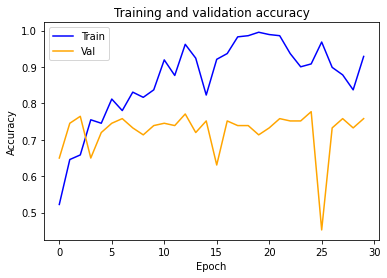

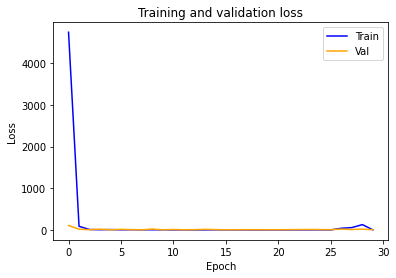

In [ ]:
plot(history)

In [ ]:
baseline_model.save(drive_root_dir+'level_4_baseline.h5')

### Transfer Learning with Inception V3

In [ ]:
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(299,299,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [ ]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [ ]:
epochs=30
history = tl_inception_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 17s 543ms/step - loss: 0.7448 - accuracy: 0.7122 - val_loss: 830.4599 - val_accuracy: 0.6561
Epoch 2/30
20/20 [==============================] - 10s 484ms/step - loss: 0.4956 - accuracy: 0.7805 - val_loss: 83.1286 - val_accuracy: 0.3567
Epoch 3/30
20/20 [==============================] - 9s 476ms/step - loss: 0.4111 - accuracy: 0.8302 - val_loss: 1.4118 - val_accuracy: 0.6624
Epoch 4/30
20/20 [==============================] - 9s 470ms/step - loss: 0.3288 - accuracy: 0.8711 - val_loss: 1.9085 - val_accuracy: 0.6242
Epoch 5/30
20/20 [==============================] - 9s 466ms/step - loss: 0.3060 - accuracy: 0.8211 - val_loss: 1.5696 - val_accuracy: 0.6688
Epoch 6/30
20/20 [==============================] - 9s 465ms/step - loss: 0.2455 - accuracy: 0.9032 - val_loss: 1.1242 - val_accuracy: 0.6433
Epoch 7/30
20/20 [==============================] - 9s 466ms/step - loss: 0.2412 - accuracy: 0.8985 - val_loss: 3.0283 - val_accuracy: 0.6306
E

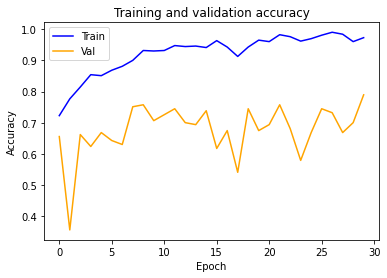

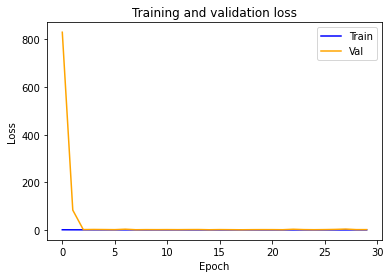

In [ ]:
plot(history)

In [ ]:
tl_inception_model.save(drive_root_dir+'level_4_tl_inception.h5')

### Inception with weights from scratch

In [ ]:
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights=None ,input_shape=(299,299,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [ ]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [ ]:
epochs=30
history = tl_inception_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 16s 519ms/step - loss: 0.9988 - accuracy: 0.6279 - val_loss: 5.6151 - val_accuracy: 0.6497
Epoch 2/30
20/20 [==============================] - 9s 455ms/step - loss: 0.5396 - accuracy: 0.7296 - val_loss: 39.4885 - val_accuracy: 0.6497
Epoch 3/30
20/20 [==============================] - 9s 457ms/step - loss: 0.4457 - accuracy: 0.8029 - val_loss: 2.3663 - val_accuracy: 0.6433
Epoch 4/30
20/20 [==============================] - 9s 459ms/step - loss: 0.4092 - accuracy: 0.8076 - val_loss: 0.7823 - val_accuracy: 0.4268
Epoch 5/30
20/20 [==============================] - 9s 460ms/step - loss: 0.3549 - accuracy: 0.8536 - val_loss: 0.6576 - val_accuracy: 0.6497
Epoch 6/30
20/20 [==============================] - 9s 461ms/step - loss: 0.4747 - accuracy: 0.7731 - val_loss: 0.8314 - val_accuracy: 0.6497
Epoch 7/30
20/20 [==============================] - 9s 464ms/step - loss: 0.3866 - accuracy: 0.8344 - val_loss: 0.7962 - val_accuracy: 0.6497
Epoc

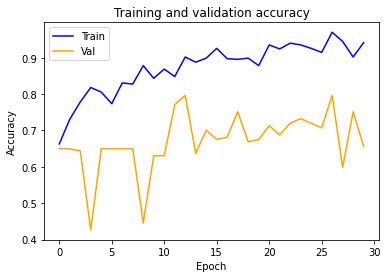

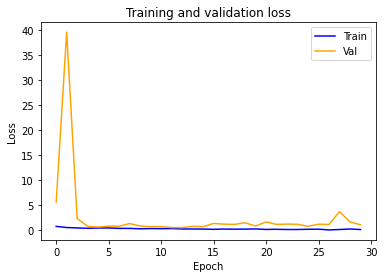

In [ ]:
plot(history)

In [ ]:
tl_inception_model.save(drive_root_dir+'level_4_tl_inception_scratch.h5')

## Level 3 Models

### Inception with weights from scratch

In [ ]:
num_classes = 2
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights=None,input_shape=(299,299,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [ ]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [ ]:
epochs=30
history = tl_inception_model.fit(
  lvl3_train_data,
  validation_data=lvl3_val_data,
  epochs=epochs
)

Epoch 1/30
51/51 [==============================] - 39s 553ms/step - loss: 0.8865 - accuracy: 0.7384 - val_loss: 20.3241 - val_accuracy: 0.6393
Epoch 2/30
51/51 [==============================] - 24s 477ms/step - loss: 0.4371 - accuracy: 0.8285 - val_loss: 0.7256 - val_accuracy: 0.6418
Epoch 3/30
51/51 [==============================] - 24s 476ms/step - loss: 0.4720 - accuracy: 0.7859 - val_loss: 0.6841 - val_accuracy: 0.7239
Epoch 4/30
51/51 [==============================] - 24s 470ms/step - loss: 0.3910 - accuracy: 0.8410 - val_loss: 0.5520 - val_accuracy: 0.7537
Epoch 5/30
51/51 [==============================] - 24s 472ms/step - loss: 0.4156 - accuracy: 0.7964 - val_loss: 0.5167 - val_accuracy: 0.7662
Epoch 6/30
51/51 [==============================] - 24s 475ms/step - loss: 0.4041 - accuracy: 0.8363 - val_loss: 0.7065 - val_accuracy: 0.7736
Epoch 7/30
51/51 [==============================] - 24s 473ms/step - loss: 0.3953 - accuracy: 0.8347 - val_loss: 0.7034 - val_accuracy: 0.696

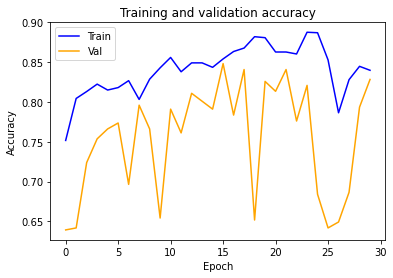

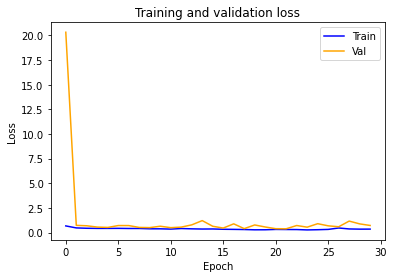

In [ ]:
plot(history)

In [ ]:
tl_inception_model.save(drive_root_dir+'level_3_tl_inception_scratch.h5')

### Inception with weights from scratch - With Data Augmentation

In [ ]:
num_classes = 2
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights=None,input_shape=(299,299,3))

data_augmentation = data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])


fine_tune_model = Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [ ]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [ ]:
epochs=30
history = tl_inception_model.fit(
  lvl3_train_data,
  validation_data=lvl3_val_data,
  epochs=epochs
)

Epoch 1/30
51/51 [==============================] - 33s 510ms/step - loss: 1.0211 - accuracy: 0.6990 - val_loss: 0.7284 - val_accuracy: 0.2910
Epoch 2/30
51/51 [==============================] - 25s 487ms/step - loss: 0.4713 - accuracy: 0.7828 - val_loss: 1.9319 - val_accuracy: 0.6418
Epoch 3/30
51/51 [==============================] - 24s 478ms/step - loss: 0.4462 - accuracy: 0.8111 - val_loss: 1.1747 - val_accuracy: 0.6418
Epoch 4/30
51/51 [==============================] - 24s 480ms/step - loss: 0.4130 - accuracy: 0.8245 - val_loss: 0.6636 - val_accuracy: 0.5149
Epoch 5/30
51/51 [==============================] - 25s 483ms/step - loss: 0.4352 - accuracy: 0.8157 - val_loss: 0.7525 - val_accuracy: 0.7388
Epoch 6/30
51/51 [==============================] - 25s 481ms/step - loss: 0.3721 - accuracy: 0.8427 - val_loss: 0.5381 - val_accuracy: 0.7637
Epoch 7/30
51/51 [==============================] - 24s 481ms/step - loss: 0.4140 - accuracy: 0.8306 - val_loss: 0.6631 - val_accuracy: 0.7711

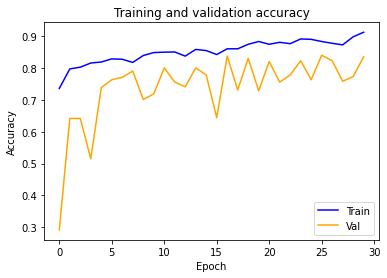

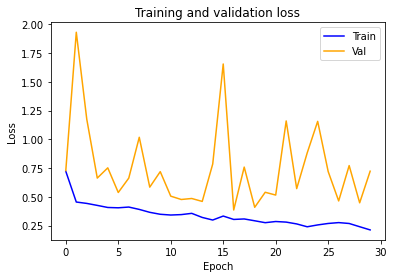

In [ ]:
plot(history)

In [ ]:
tl_inception_model.save(drive_root_dir+'level_3_tl_inception_scratch_data_aug.h5')

## Multi-level Model

In [26]:
num_classes = 2
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights=None,input_shape=(299,299,3))


fine_tune_model = Sequential([
  layers.Flatten(),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [27]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [28]:
epochs=10
history = tl_inception_model.fit(
  multi_lvl_train_data,
  validation_data=multi_lvl_val_data,
  epochs=epochs
)

Epoch 1/10
71/71 [==============================] - 25s 272ms/step - loss: 5.5523 - accuracy: 0.6494 - val_loss: 176779.7188 - val_accuracy: 0.7089
Epoch 2/10
71/71 [==============================] - 18s 257ms/step - loss: 1.0764 - accuracy: 0.7132 - val_loss: 415.3708 - val_accuracy: 0.5571
Epoch 3/10
71/71 [==============================] - 18s 257ms/step - loss: 3.0059 - accuracy: 0.6443 - val_loss: 7364.8779 - val_accuracy: 0.3893
Epoch 4/10
71/71 [==============================] - 18s 257ms/step - loss: 1.9549 - accuracy: 0.6857 - val_loss: 11.0488 - val_accuracy: 0.4071
Epoch 5/10
71/71 [==============================] - 18s 257ms/step - loss: 1.0034 - accuracy: 0.7018 - val_loss: 708.8649 - val_accuracy: 0.6946
Epoch 6/10
71/71 [==============================] - 18s 257ms/step - loss: 1.2176 - accuracy: 0.6630 - val_loss: 152776.4375 - val_accuracy: 0.6982
Epoch 7/10
71/71 [==============================] - 18s 257ms/step - loss: 1.2790 - accuracy: 0.7182 - val_loss: 10.7682 - v

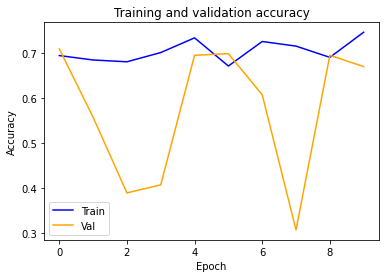

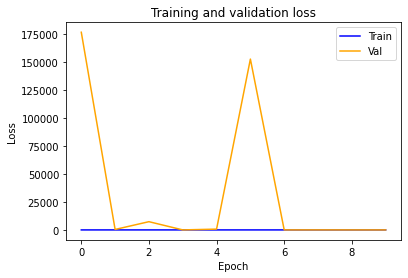

In [29]:
plot(history)

In [30]:
tl_inception_model.save(drive_root_dir+'multilevel_inception.h5')

# Evaluate and Compare Models

In [31]:
test_data_slides = ['tumor_096', 'tumor_101', 'tumor_110']

In [32]:
from evaluation import heatmap_on_test

## Baseline model evaluation

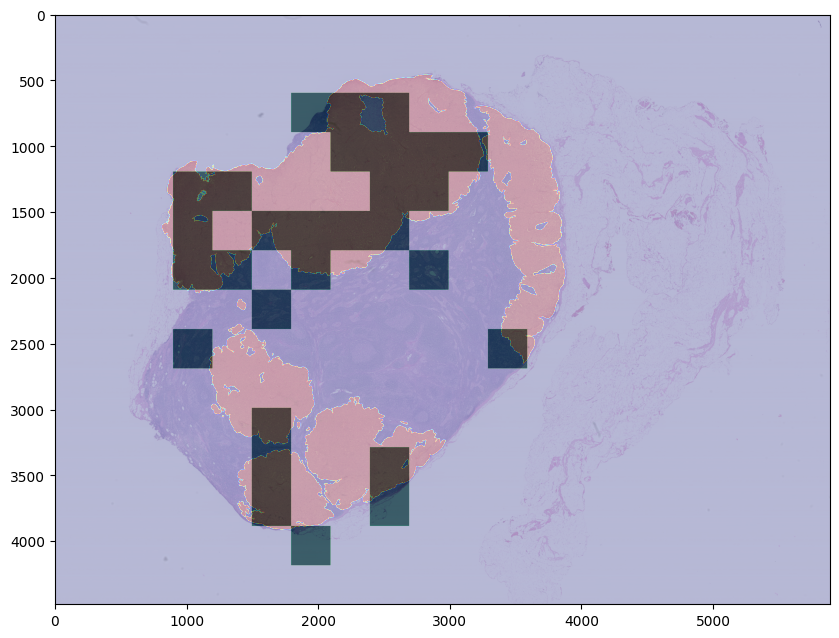

In [ ]:
model_path = drive_root_dir+'level_4_baseline.h5'
level = 4
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [ ]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            176              2
Actual Positive             61             27

precision: 0.9310344827586207
recall: 0.3068181818181818


## Transfer Learning with Inception V3 evaluation

### Level 4

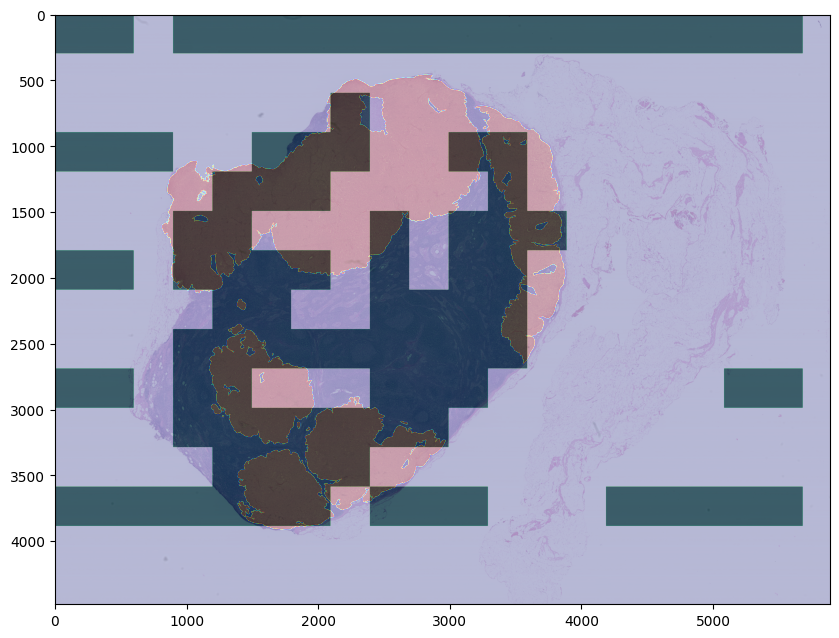

In [ ]:
model_path = drive_root_dir+'level_4_tl_inception.h5'
level = 4
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [ ]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            129             49
Actual Positive             41             47

precision: 0.4895833333333333
recall: 0.5340909090909091


### Level 4 - From Scratch

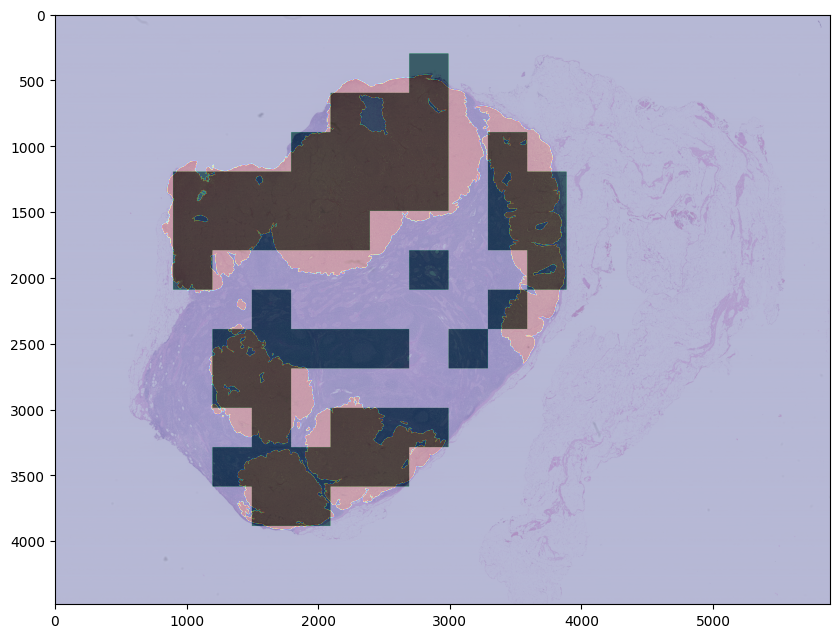

In [ ]:
model_path = drive_root_dir+'level_4_tl_inception_scratch.h5'
level = 4
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [ ]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            173              5
Actual Positive             44             44

precision: 0.8979591836734694
recall: 0.5


### Level 3 - From Scratch

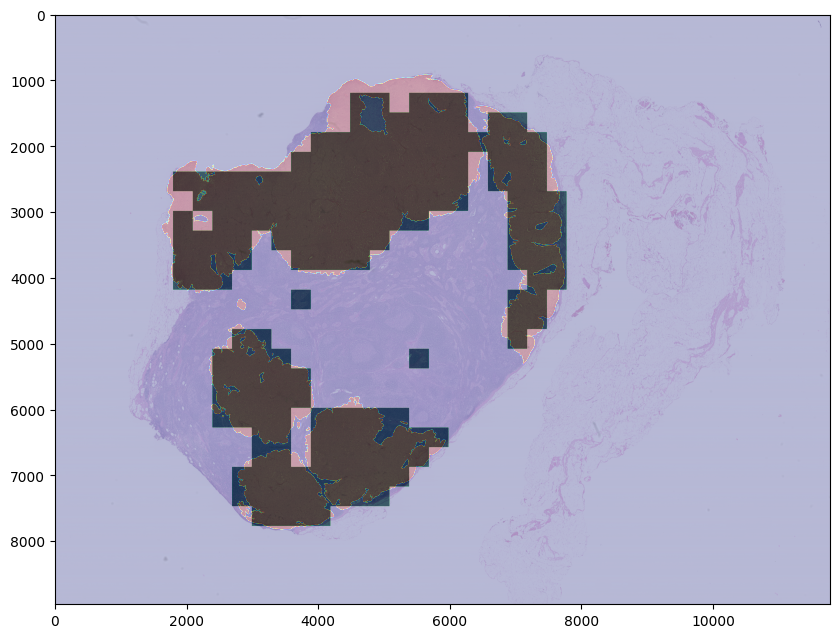

In [ ]:
model_path = drive_root_dir+'level_3_tl_inception_scratch.h5'
level = 3
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [ ]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            854              2
Actual Positive             91            184

precision: 0.989247311827957
recall: 0.6690909090909091


### Level 3 - Inception with weights from scratch - With Data Augmentation

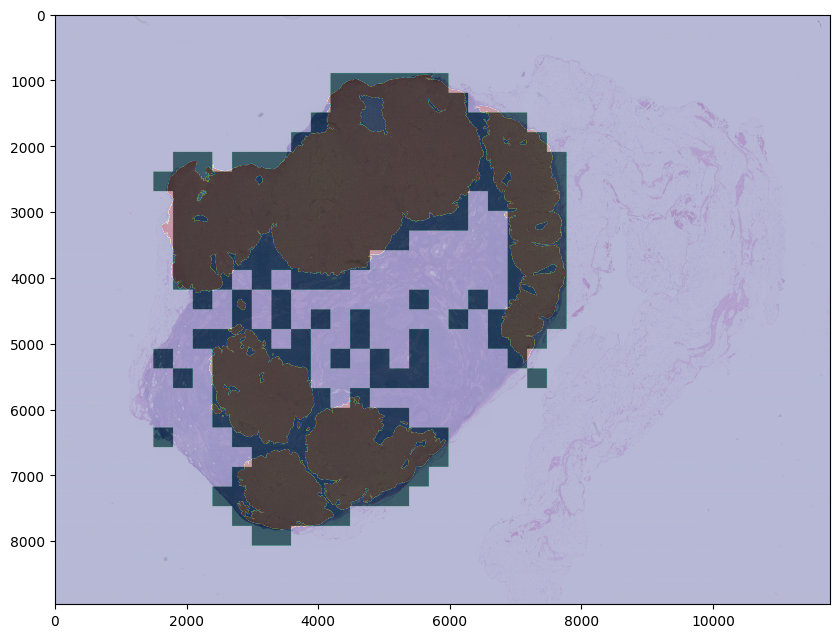

In [ ]:
model_path = drive_root_dir+'level_3_tl_inception_scratch_data_aug.h5'
level = 3
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [ ]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            832             24
Actual Positive             33            242

precision: 0.9097744360902256
recall: 0.88


## Multi-level model evaluation

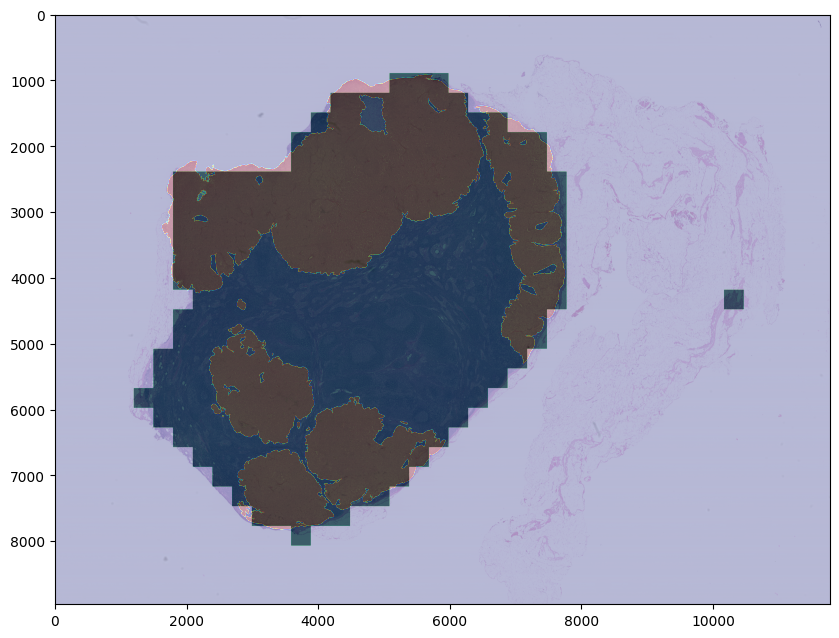

In [35]:
model_path = drive_root_dir+'multilevel_inception.h5'
level = 3
slice_size = 299
model = tf.keras.models.load_model(model_path)
cnf_matrix, precision, recall = heatmap_on_test(level,test_data_slides[2],slice_size,model,class_names).generate()

In [36]:
print(pd.DataFrame(cnf_matrix, columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive']))
print(f'\nprecision: {precision}')
print(f'recall: {recall}')

                 Pred Negative  Pred Positive
Actual Negative            752            104
Actual Positive             34            241

precision: 0.6985507246376812
recall: 0.8763636363636363
